Initialization:

In [4]:
%reload_ext snakeviz
%matplotlib inline
%run SBRG.py

#Core Code

## Pauli Algebra
- Each Pauli monomial (call a `term`) is represented as a list like `[mat, val]`, where
  - `mat` is a dict recording the Pauli matrix indices in the sparse form, as `{3: 1, 5: 2, ..}` 
  - `val` is a **real** number recording the coefficient of that term.
     - We will only deal with real coefficient now!
- Each Pauli polynomial is represented as a list of Pauli monomials.

###Dot Product
- Single-bit dot product rule is stored in a dict `DOT_RULES`, each entry is  like `(i,j): (k,n)` formulating $\sigma^i\sigma^j=\text{i}^n\sigma^k$ (where $n=0,\pm1$ is the power of $\text{i}$).
- Multi-bit dot product is carried out by mapping the `DOT_RULES` to the pair of Pauli indices, and collect the resulting indices and powers. The posers are sum together to obtain the finnal power.
- `dot(term1, term2, n0 = 0)` dot product of two terms. The optional `n0` gives the addtional powers of $\text{i}$ to be timed, the result will be: $$\text{i}^{n_0}h_{[\mu]_1}h_{[\mu]_2}\sigma^{[\mu]_1}\sigma^{[\mu]_2}$$
   - subroutine `merge(mat1_get, mat2_get, mat1_keys, mat2_keys)` merges two dicts `mat1` and `mat2` (providing the get method and the keys), missing keys are treated by 0 value. This creates a list of non-trivial pair of Pauli indices `merged = [[i, mu1, mu2], ...]` where `i` index the qubit position and `mu1`, `mu2` are Pauli indices to be dotted.
   - subroutine `dotover(merged)` transform every element `[i, mu1, mu2]` in `merged` to `[i, mu, n]` by applying the DOT_RULES
   - `powofi(merged, n0)` calculate the power of $\text{i}$ (mod 4) from the dotted `merged` given the shift of `n0`.
   - `newmat(merged)` construct new matrix dict from the dotted `merged`.

In [2]:
a1 = [{0: 2, 1: 2, 2: 3}, 0.06389459153589115]
a2 = [{0: 1, 1: 1, 3: 3}, -0.030666385691511793]
dot(a1, a2)

[{0: 3, 1: 3, 2: 3, 3: 3}, 0.001959416187641243]

###Find Rotation to Diagonalize Pauli Matrix
**Goal**: rotate $\sigma^{[0|3..][\mu]}$ to the block diagonal form $\sigma^{[0..]3[0..]}$ with 3 at the intent position, and the transformation must respect all the $\sigma^3$ symmetries before the intent position.

**Algorithm**:
- If $[\mu]$ contains 1|2 (once the first 1|2 found, break): rotate that bit to 3 while eliminating other bits to 0 by `C4`, and move 3 to the the intent position by `SWAP` if necessary.
- Elseif $[\mu]$ has no 1|2 but 3 exist:
  - If there are multiple 3's (*for the whole indices*): need two `C4` rotations
    - If there is a 3 at the intent position: do the double-`C4` at that position, and no `SWAP` needed.
    - Elseif the intent position is 0: do the double-`C4` at the position of the last 3, followed by `SWAP`.
  - Elseif there is only one 3: just do a `SWAP` (if 3 sits at intent position, no transformation needed).
- Else $[\mu]$ is $[0..]$: no transform needed (but such matrixes should have already been ascribed to the conserved quantity and should not appear).

In [3]:
find_rotation({0: 1, 5: 3}, 0)

[['C4', [{0: 2, 5: 3}, -1.0]]]

The result of `find_rotation` is a list of unitary transformations: each element is of the following form:
- `['C4',[{...},z]]`: C4 rotation with C4 generator.
- `['SWAP',[i, j]]`: SWAP operation btw i & j bit.

The unitary transformations are implemented by
- `unitary_fd(Us, H)`: forward transfrom from boundary to bulk,
- `unitary_bk(Us, H)`: backward transform from bulk to boundary (`Us` still given by the forward order),
where `Us` is a list of transformations (action implemented in sequencial order), and `H` is the Pauli polynomial (or a list of Pauli monomials) to be acted.

In [4]:
H = [[{0: 3, 5: 3, 7: 3}, 1], [{0: 3, 5: 2, 7: 1}, 1]]
Us = find_rotation(H[0][0],0)
print(Us)
unitary_fd(Us,H)
H

[['C4', [{0: 2, 5: 3, 7: 3}, 1.0]], ['C4', [{0: 2}, -1]]]


[[{0: 3}, 1.0], [{0: 3, 5: 1, 7: 2}, 1.0]]

In [5]:
unitary_bk(Us, H)
H

[[{0: 3, 5: 3, 7: 3}, 1.0], [{0: 3, 5: 2, 7: 1}, 1.0]]

###Compute and Control 2nd Order Perturbation
Given the off-diagonal terms $\Sigma_0=\sum_{[\mu]}h_{[\mu]}\sigma^{[\mu]}$ and $H_0=h_0\sigma^{3[0..]}$, the 2nd order perturbation is then given by:
$$\begin{split}
H_2 &= \frac{1}{2h_0^2} H_0\Sigma_0^2 = \frac{1}{2h_0} \sigma^{3[0..]}\Sigma_0^2\\
&=\Big(\frac{1}{2h_0}\sum_{[\mu]}h_{[\mu]}^2\Big)\sigma^{3[0..]}+ \sum_{[\mu]_1<[\mu]_2}\frac{h_{[\mu]_1}h_{[\mu]_2}}{h_0}\;\sigma^{3[0..]}\,\Re[\sigma^{[\mu]_1}\sigma^{[\mu]_2}].
\end{split}$$
- the first term is a backward correction to the leading energy scale,
- the second term generates new terms and should be controlled,
- $\Re$ of Pauli matrices is non-vanishing only of the matrices commute.

The growth the Hamiltonian is controlled by:
- energy scale truncation `min_scale`: terms with energy scale less then `min_scale` will be neglected,
- term number truncation `max_rate`: the perturbed H contains at most `max_rate`$\times$ number of $H_\text{offdiag}$ terms.

##Spectrum Bifurcation RG
Generic Hamiltonian: qubit models
$$H=\sum_{[\mu]}h_{[\mu]}\sigma^{[\mu]},$$
where $\sigma^{[\mu]}=\sigma^{\mu_1}\otimes\sigma^{\mu_2}\otimes\sigma^{\mu_3}\otimes\cdots$ denotes the product of Pauli matrices (quantum gates). The key assumption is $h_{[\mu]}$ should be sufficiently random.

###RG Kernel
**Algorithm**:
- Find leading energy scale
- Find Clifford algebra rotation $R$ that
  - diagonalize the leading energy scale
  - at the same time transform the other terms in the Hamiltonian (note that the term ordering is lost in this step)
- Gather diagonal and off-diagonal terms
    $$H = H_0 + \Delta_0 + \Sigma_0$$
   where $H_0^2 = h_0^2$, $H_0\Delta_0 = \Delta_0H_0$, $H_0\Sigma_0 = -\Sigma_0H_0$.
  - diagonal terms goes to new Hamiltonian
  - off-diagonal terms renormalized by 2nd order perturbation, which generates effective terms in the diagonal blocks.[1]
    $$H = H_0 + \Delta_0 + \frac{1}{2h_0^2} H_0\Sigma_0^2.$$
    The perturbation can be carried out by the unitary transform
    $$U = \exp\left(-\frac{1}{2h_0^2}H_0\Sigma_0\right).$$

###Build Circuit
- Clifford gates are collected in forward order along the RG flow. As the flow finishes, `self.gates` will hold the Clifford gates $R = R_\text{C4}R_\text{SWAP}R_\text{C4}R_\text{C4}R_\text{SWAP}R_\text{SWAP}\cdots$
- To build the circuit,
  - first move all the SWAP gates to the end by commuting over the C4 gates.
    $$ \text{physical} \xrightarrow{C_4} \text{emergent (ordered by realspace location)} \xrightarrow{SWAP} \text{emergent (ordered by energy scale)}$$
  - then absorb SWAP gates to Heff by backward action. (In this way, the locality is mostly preserved.)
  
**Algorithm**: reorder Heff mat inds
- starting from a ordered list of inds: `blk = [0,1,2...]` the elements labels the qubit positions of energy-scale-ordered Hilbert space. 
- apply SWAP in backward order to the list, permutes the energy-scale labels to the real-space positions.
- so the mat ind of Heff must be brought back to real-sapce by the value-to-index mapping of `blk`.

###Test

In [6]:
model = TFIsing(4, J=1,K=0,h=1,alpha_J=1.,alpha_K=1.,alpha_h=1.)

In [72]:
%run SBRG.py
system = SBRG(model)
system.max_rate = 0.5
system.flow()
len(system.trash)

764

Profiling:

In [12]:
system = SBRG(model)
% snakeviz system.flow()

 
*** Profile stats marshalled to file '/var/folders/tl/lwpcq5qj049ftcj7pvhkzv_h0000gn/T/tmp3483ly'. 


Benchmark with Mathematica:

In [7]:
model = TFIsing(16, J=1,K=1,h=1,alpha_J=0.2,alpha_K=0.2,alpha_h=0.2)
export('model', model)
system = SBRG(model)
system.tol = 1.e-8
system.max_rate = 2.
system.recover = False
system.flow()
export('Heff',system.Heff)
system.trash

[]

##Model Hamiltonians
###Transverse Field Ising with Interaction
For random $J_i$, $K_i$, $h_i$ drawn from a beta distribution,
$$H=-\sum_{i}J_i \sigma_i^x\sigma_{i+1}^x+K_i \sigma_i^z\sigma_{i+1}^z+h_i \sigma_i^z.$$

#Physics
##Level Statistics
###Flow of Energy Scale Distribution

In [407]:
realization = 100
alpha = 1.0
N0 = 128
steps = [0, 32, 32, 32, 16, 8, 4]
data = {}
N = N0
for stp in steps:
    N -= stp
    data[N] = []
for i in range(realization):
    model = TFIsing(N0, J=1,K=0,h=1,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha)
    system = SBRG(model)
    for stp in steps:
        system.flow(stp)
        data[system.tot_bits - system.tau_bits].extend([abs(val) for (mat, val) in system.H])
export('RGflow_J1K0h1_a10_128', data)

In [428]:
realization = 100
alpha = 1.0
N0 = 256
steps = [0, 64, 32, 32, 32, 32, 16, 16, 16, 8, 4]
data = {}
N = N0
for stp in steps:
    N -= stp
    data[N] = []
for i in range(realization):
    model = TFIsing(N0, J=1,K=1,h=1,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha)
    system = SBRG(model)
    for stp in steps:
        system.flow(stp)
        data[system.tot_bits - system.tau_bits].extend([abs(val) for (mat, val) in system.H])
export('RGflow_J1K1h1_a10_256', data)

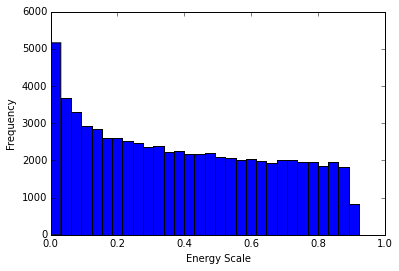

In [435]:
hist_plot(data[192])

###E-Tensor Distribution

**MAKE SURE**: Data collected with back correction turned off.

In [357]:
alpha = 1.0
realization = 200
ns = list(range(1,11))
data = {n: [] for n in ns}
for i in range(realization):
    model = TFIsing(128, J=0,K=1,h=1,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha)
    system = SBRG(model)
    system.max_rate = 3.
    system.flow()
    for n in ns:
        data[n].extend([abs(val) for [mat, val] in system.Heff if len(mat) == n])
#export('Estat_J0K1h1_a10_on', data)

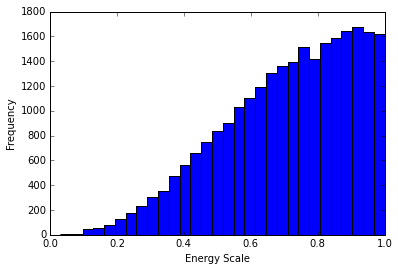

In [362]:
hist_plot(data[1])

###Conserved Quantity
Reconstruct emergent conserved quantities in terms of the original qubits.

In [200]:
system.taus

[[{1: 1, 2: 1}, 0.9893477018529714],
 [{0: 1, 7: 1}, 0.9765818944947422],
 [{2: 1, 3: 1}, 0.9362473961730203],
 [{0: 1, 1: 1}, 0.819643519828954],
 [{6: 1, 7: 1}, 0.814223205952669],
 [{4: 1, 5: 1}, 0.6193696176364678],
 [{3: 1, 4: 1}, 0.6055116251502947],
 [{0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 2, 6: 2, 7: 3}, -0.0]]

Export data of conserved quantity

In [199]:
alpha = 1.
model = TFIsing(8, J=1.,K=0.,h=0.01,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha)
system = SBRG(model)
system.max_rate = 2.
system.flow()
#export('system_test', system)
len(system.trash)

0

###Stablizer State and Entanglement Entropy
**Push Gates:**
The circuit is a unitary transformation $U=R_1R_2R_3\cdots$. To push $R_2$ over $R_3$ corresponds to $R_3 \to R_2 R_3 R_2^\dagger$, so it is a *backward* unitary transform by $R_2$ on $R_3$.

In [5]:
model = TFIsing(8, J=1.,K=0.5,h=0.0,alpha_J=1.,alpha_K=1.,alpha_h=1.)
system = SBRG(model).flow()
export('system_test', system)

In [11]:
system.entropy([3,4])

1.0

In [7]:
system.taus

[[{6: 1, 7: 1}, 0.9267800320583462],
 [{5: 1, 6: 1}, 0.8705916569585502],
 [{0: 1, 1: 1}, 0.8269787726190353],
 [{0: 1, 7: 1}, 0.6695208160712739],
 [{4: 1, 5: 1}, 0.6356709745095795],
 [{2: 1, 3: 1}, 0.3064095387647209],
 [{1: 1, 2: 1}, 0.3930882550300293],
 [{0: 2, 1: 2, 2: 2, 3: 3, 4: 3, 5: 2, 6: 2, 7: 2}, -0.017668802970686424]]